Example authorship comming from: https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb 

# Using Lime with Pytorch

In this tutorial we will show how to use Lime framework with Pytorch. Specifically, we will use Lime to explain the prediction generated by one of the pretrained ImageNet models.

Let's start with importing our dependencies. This code is tested with Pytorch 1.0 but should work with older versions as well.

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

import torch
from torchvision.transforms import transforms

import torch.nn.functional as F

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Load our test image and see how it looks.

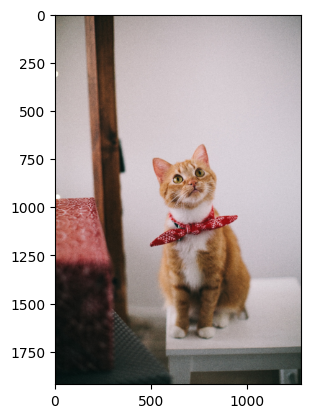

In [2]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('data/cat.png')
plt.imshow(img)

We need to convert this image to Pytorch tensor and also apply whitening as used by our pretrained model.

In [3]:
def get_input_tensors(img):
    # resize and take the center part of image to what our model expects
    transf = transforms.Compose([
        transforms.Resize((640, 640)), # adapte to what yolo expects
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                             std=[0.229, 0.224, 0.225])      
    ])    
    
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

Load the pretrained model --YOLOv5-- available in Ultralytics: https://docs.ultralytics.com/models/yolov5/#key-features

In [4]:
from ultralytics import YOLO
model = YOLO('models/yolov5mu.pt')  # pretrained YOLOv5 model

Get the predicition for our image.


0: 640x640 1 cat, 1 tie, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 590.5ms postprocess per image at shape (1, 3, 640, 640)

Confidence | Objectedness score: 0.9354095458984375
Class name: ***cat*** (index: 15)

Confidence | Objectedness score: 0.7321256399154663
Class name: ***tie*** (index: 27)


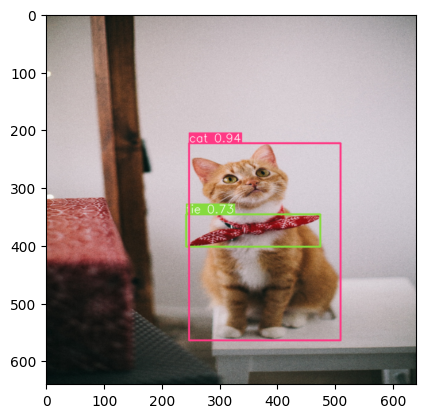

In [5]:
img_t = get_input_tensors(img)
# logits = model(img_t) # it trains by default
results = model.predict(img_t, 
                        conf=0.5, # for NMS
                        iou=0.7  
                        ) # https://docs.ultralytics.com/modes/predict/#inference-arguments

# show results
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    
    for box in boxes:
        print('\nConfidence | Objectedness score:',box.conf.item())
        _class_idx = box.cls.item()
        print('Class name: ***{}*** (index: {})'
              .format(result.names[_class_idx],int(_class_idx)))
        
    # result.show()  # display to screen
    _res_np = result.plot() #Plots the detection results. Returns a numpy array of the annotated image (might not plot at first, but we can use the returned numpy object to plot it with plt.imshow)
    plt.imshow(_res_np)
    result.save(filename='data/cat_yolo_result.jpg')  # save to disk

Classes are:
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}


We are getting ready to use Lime. Lime produces the array of images from original input image by pertubation algorithm. So we need to provide two things: (1) original image as numpy array (2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output. 

For Pytorch, first we need to define two separate transforms: (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.

Test it for multiple images

In [6]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((640, 640)),
    ])    

    return transf

def get_preprocess_transform():   
    transf = transforms.Compose([
        transforms.ToTensor(),
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

Now we are ready to define classification function that Lime needs. The input to this function is numpy array of images where each image is ndarray of shape (channel, height, width). The output is numpy aaray of shape (image index, classes) where each value in array should be probability for that image, class combination.

In [7]:
def batch_predict(images, conf_th=0.5):
    with torch.no_grad():
        batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
        print(batch.shape)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        batch = batch.to(device)
        
        results = model.predict(batch, conf=conf_th)

    return results


def get_probab_class(images, target_class=15, conf_th=0.1):
    results = batch_predict(images, conf_th)
    one_hot_results = []
    _length_dataset = 80 #len(r.names.keys())
    
    # for all images
    for _i,result in enumerate(results):

        _enter_aux = False
        # generate a one-hot encoding
        one_hot = np.zeros(_length_dataset)
        
        for box in result.boxes:
            _class_index = int(box.cls.item())
        
            if _class_index == target_class:
                one_hot[_class_index] = 1
                _enter_aux = True
                
        if _enter_aux is False:
            one_hot = np.full(_length_dataset,1/_length_dataset)
        
        one_hot_results.append(one_hot)
            
    return np.array(one_hot_results)

def get_probab_class_wrapper(target_class=15, conf_th=0.1):
    """
    Wrapper function to create a callable for LimeImageExplainer
    that accepts only the images argument, fixing target_class and conf_th.
    """
    def get_probab_class(images):
        results = batch_predict(images, conf_th)
        one_hot_results = []
        _length_dataset = 80  # Assuming fixed length, replace with dynamic if needed
        
        # for all images
        for result in results:
            _enter_aux = False
            # generate a one-hot encoding
            one_hot = np.zeros(_length_dataset)
            
            for box in result.boxes:
                _class_index = int(box.cls.item())
            
                if _class_index == target_class:
                    one_hot[_class_index] = 1
                    _enter_aux = True
                    
            if not _enter_aux:
                one_hot = np.full(_length_dataset, 1/_length_dataset)
            
            one_hot_results.append(one_hot)
                
        return np.array(one_hot_results)
    
    return get_probab_class  # Return the customized function
            
    

Let's test our function for the sample image.

In [8]:
# results = batch_predict([pill_transf(img)])

# for r in results:
    
#     print()
#     for box in r.boxes:
#         print('\nConfidence | Objectedness score:',box.conf.item())
#         _class_idx = box.cls.item()
#         print('Class name: ***{}*** (index: {})'
#                 .format(result.names[_class_idx],int(_class_idx)))
        
test_pred = get_probab_class([pill_transf(img)], target_class=15)
print('Predicted classs: ', test_pred.squeeze().argmax())
print('Predicted values type:',type(test_pred))
print('Predicted values shape:',test_pred.shape)
print('Predicted values:',test_pred)

torch.Size([1, 3, 640, 640])

0: 640x640 1 cat, 1 tie, 1 bed, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Predicted classs:  15
Predicted values type: <class 'numpy.ndarray'>
Predicted values shape: (1, 80)
Predicted values: [[          0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           1           0           0           0           0           0           0           0           0           0           0
            0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0
            0           0           0           0           0           0           0    

Test it for multiple images

In [9]:
img1 = get_image('data/cat.png')
img2 = get_image('data/ski.png')
test_pred = get_probab_class([pill_transf(img1), pill_transf(img2)],
                             target_class=15)
print('\nTwo predictions made:',test_pred.shape)

for _i,t in enumerate(test_pred):
    print('{} - image represents class with index: {}'.format(_i,t.squeeze().argmax()))
    # print(t)

torch.Size([2, 3, 640, 640])

0: 640x640 1 cat, 1 tie, 1 bed, 59.1ms
1: 640x640 1 person, 2 skiss, 59.1ms
Speed: 0.0ms preprocess, 59.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

Two predictions made: (2, 80)
0 - image represents class with index: 15
1 - image represents class with index: 0


Import lime and create explanation for this prediciton.

In [10]:
from lime import lime_image

# Inherits from scikit-image: https://github.com/marcotcr/lime/blob/master/lime/wrappers/scikit_image.py
# Check segmentation algorithms: https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.felzenszwalb
from lime.wrappers.scikit_image import SegmentationAlgorithm 


## TIE as target class

In [11]:
explainer = lime_image.LimeImageExplainer() #https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image
segmenter = SegmentationAlgorithm('slic',n_segments=100) 

# cat=15
# tie=27
custom_classifier_fn = get_probab_class_wrapper(target_class=27, conf_th=0.5)


explanation = explainer.explain_instance(image=np.array(pill_transf(img)), 
                                         classifier_fn=custom_classifier_fn, # classification function
                                         top_labels=3, #produce explanations for the K labels with highest prediction probabilities
                                         hide_color=0, 
                                         num_samples=1000, # number of images that will be sent to classification function
                                         segmentation_fn = segmenter, # SegmentationAlgorithm, wrapped skimage
                                         num_features = 15,
                                         ) 

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([10, 3, 640, 640])

0: 640x640 1 cat, 1 tie, 15.0ms
1: 640x640 1 bird, 15.0ms
2: 640x640 (no detections), 15.0ms
3: 640x640 (no detections), 15.0ms
4: 640x640 (no detections), 15.0ms
5: 640x640 (no detections), 15.0ms
6: 640x640 (no detections), 15.0ms
7: 640x640 (no detections), 15.0ms
8: 640x640 (no detections), 15.0ms
9: 640x640 (no detections), 15.0ms
Speed: 0.0ms preprocess, 15.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
torch.Size([10, 3, 640, 640])

0: 640x640 1 cat, 1 tie, 5.8ms
1: 640x640 (no detections), 5.8ms
2: 640x640 1 cat, 5.8ms
3: 640x640 (no detections), 5.8ms
4: 640x640 (no detections), 5.8ms
5: 640x640 1 tie, 5.8ms
6: 640x640 (no detections), 5.8ms
7: 640x640 (no detections), 5.8ms
8: 640x640 1 traffic light, 5.8ms
9: 640x640 1 bird, 5.8ms
Speed: 0.0ms preprocess, 5.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
torch.Size([10, 3, 640, 640])

0: 640x640 (no detections), 5.8ms
1: 640x640 1 cake, 5.8ms
2: 640x64

Let's assess the number of features/superpixels generated by the model

In [12]:
# Assuming 'explanation' is your explanation object from LIME
segments = explanation.segments
unique_features = np.unique(segments)

# The total number of unique features considered by the model
num_unique_features = len(unique_features)

print(f"Total unique features (superpixels) considered: {num_unique_features}")

Total unique features (superpixels) considered: 85


Let's use mask on image and see the areas that are encouraging the top prediction.

mask shape: (640, 640)


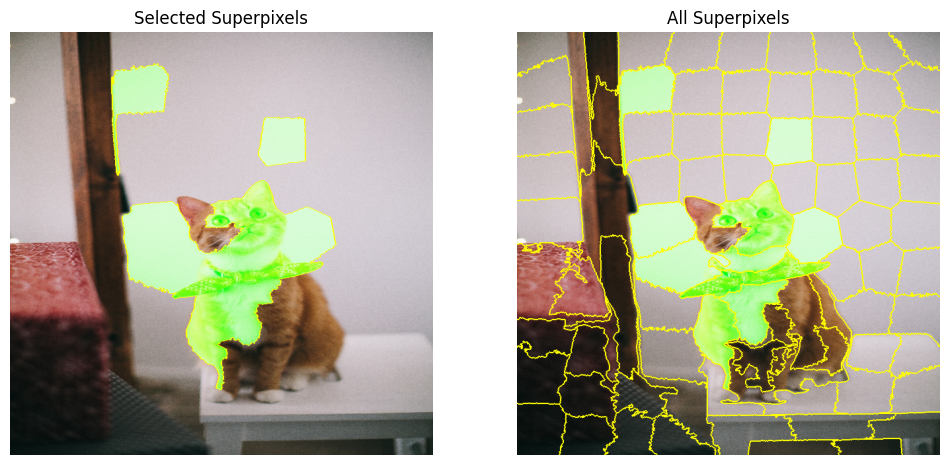

In [13]:
from skimage.segmentation import mark_boundaries #Return image with boundaries between labeled regions highlighted (https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.mark_boundaries)

target_label = explanation.top_labels[0]

# showing both Positive & Negative superpixels
temp, mask = explanation.get_image_and_mask(label=target_label, 
                                            positive_only=False, # if True, only take superpixels that positively contribute to the prediction of the label.
                                            num_features=10, #  number of superpixels to include in explanation
                                            hide_rest=False  # if True, make the non-explanation part of the return image gray
                                            )
print("mask shape:",mask.shape)
img_boundry1 = mark_boundaries(temp/255.0, mask)
# plt.imshow(img_boundry1)

segments = explanation.segments  # This assumes you have access to the 'segments' from your explanation object
img_with_all_boundaries = mark_boundaries(temp / 255.0, segments)


# Creating subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plotting the image with selected superpixels on the left
ax[0].imshow(img_boundry1)
ax[0].set_title('Selected Superpixels')
ax[0].axis('off')  # Hide the axes

# Plotting the image with all superpixels on the right
ax[1].imshow(img_with_all_boundaries)
ax[1].set_title('All Superpixels')
ax[1].axis('off')  # Hide the axes

plt.show()

Highlight only those features that POSITIVELY contribute to the explanations

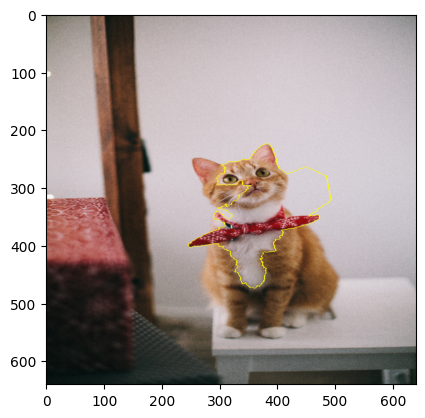

In [14]:
target_label = explanation.top_labels[0]

# showing only positve
temp, mask = explanation.get_image_and_mask(label=target_label,
                                            positive_only=True, 
                                            num_features=5, 
                                            hide_rest=False)

img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

Highlight only those features that NEGATIVELY contribute to the explanations

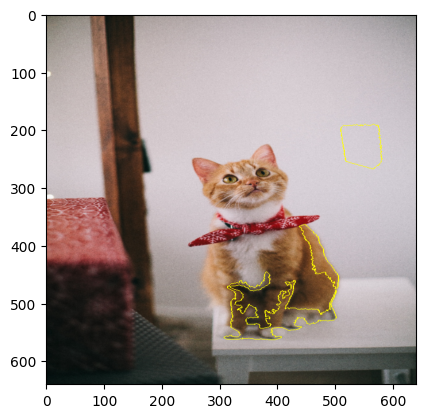

In [15]:
# showing only negative
temp, mask = explanation.get_image_and_mask(label=target_label,
                                            positive_only=False,
                                            negative_only=True, 
                                            num_features=15, 
                                            hide_rest=False)

img_boundry3 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry3)

## CAT as target class

In [16]:
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer() #https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image
segmenter = SegmentationAlgorithm('slic',n_segments=100) 

# cat=15
# tie=27
custom_classifier_fn = get_probab_class_wrapper(target_class=15, conf_th=0.5)


explanation = explainer.explain_instance(image=np.array(pill_transf(img)), 
                                         classifier_fn=custom_classifier_fn, # classification function
                                         top_labels=3, #produce explanations for the K labels with highest prediction probabilities
                                         hide_color=0, 
                                         num_samples=1000, # number of images that will be sent to classification function
                                         segmentation_fn = segmenter, # SegmentationAlgorithm, wrapped skimage
                                         num_features = 15,
                                         ) 

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([10, 3, 640, 640])

0: 640x640 1 cat, 1 tie, 6.1ms
1: 640x640 (no detections), 6.1ms
2: 640x640 (no detections), 6.1ms
3: 640x640 (no detections), 6.1ms
4: 640x640 (no detections), 6.1ms
5: 640x640 (no detections), 6.1ms
6: 640x640 (no detections), 6.1ms
7: 640x640 (no detections), 6.1ms
8: 640x640 (no detections), 6.1ms
9: 640x640 (no detections), 6.1ms
Speed: 0.0ms preprocess, 6.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
torch.Size([10, 3, 640, 640])

0: 640x640 (no detections), 5.8ms
1: 640x640 1 cat, 5.8ms
2: 640x640 1 tie, 5.8ms
3: 640x640 1 cat, 5.8ms
4: 640x640 (no detections), 5.8ms
5: 640x640 (no detections), 5.8ms
6: 640x640 (no detections), 5.8ms
7: 640x640 (no detections), 5.8ms
8: 640x640 (no detections), 5.8ms
9: 640x640 (no detections), 5.8ms
Speed: 0.0ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
torch.Size([10, 3, 640, 640])

0: 640x640 1 cat, 5.5ms
1: 640x640 (no detections), 5.5ms
2: 640x640

Visualize 

Total unique features (superpixels) considered: 85


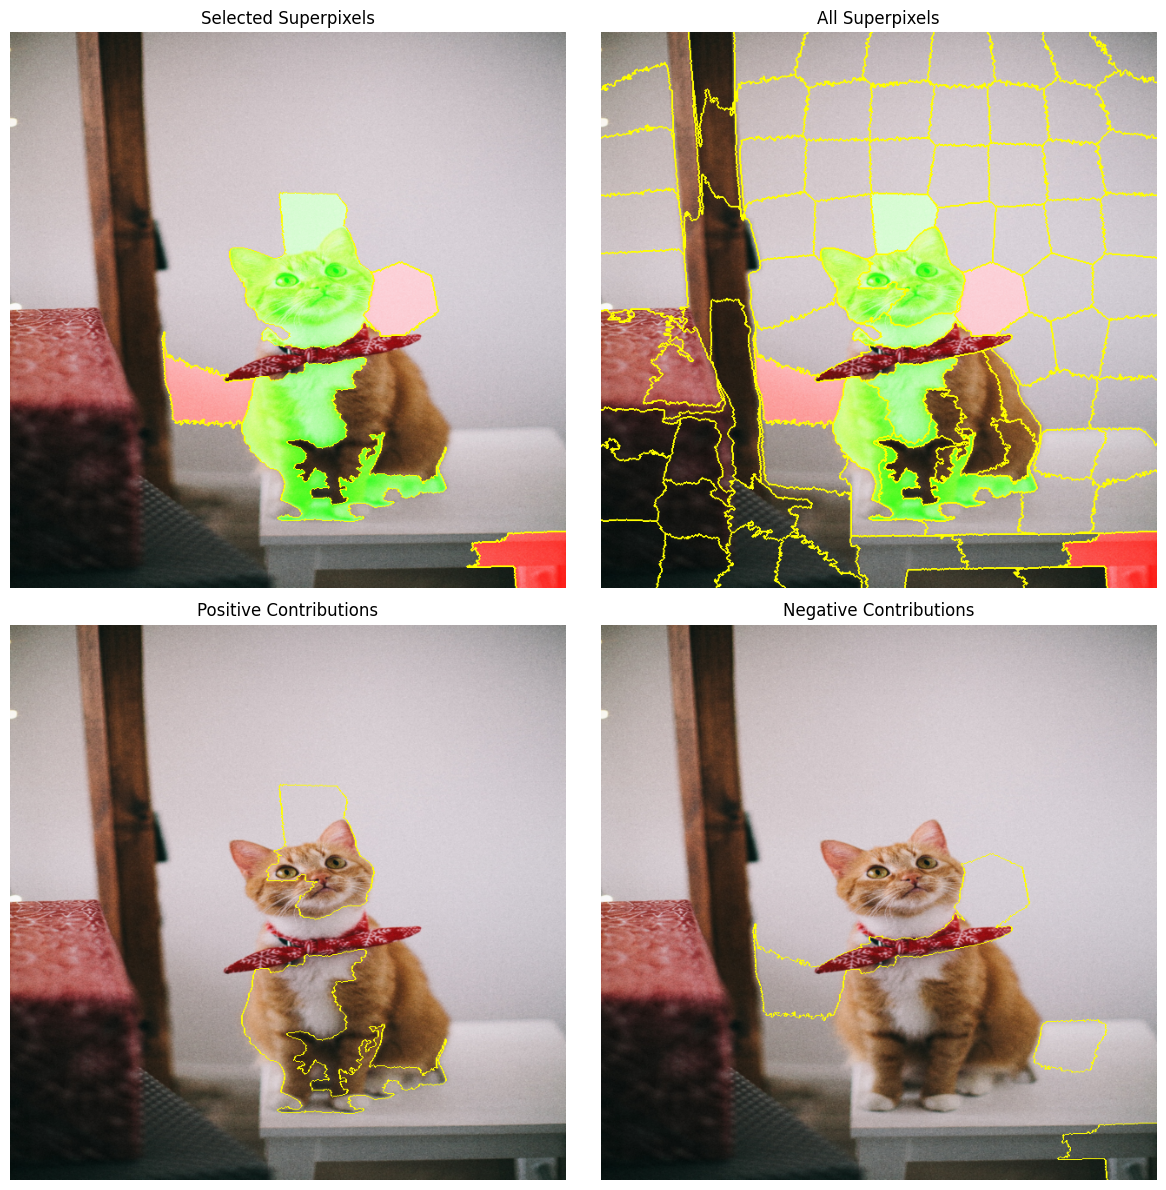

In [17]:
# Assuming 'explanation' is your explanation object from LIME
segments = explanation.segments
unique_features = np.unique(segments)

# The total number of unique features considered by the model
num_unique_features = len(unique_features)

print(f"Total unique features (superpixels) considered: {num_unique_features}")


# ****Let's use mask on image and see the areas that are encouraging the top prediction. ***

target_label = explanation.top_labels[0]

# showing both Positive & Negative superpixels
temp, mask = explanation.get_image_and_mask(label=target_label, 
                                            positive_only=False, # if True, only take superpixels that positively contribute to the prediction of the label.
                                            num_features=10, #  number of superpixels to include in explanation
                                            hide_rest=False  # if True, make the non-explanation part of the return image gray
                                            )
# Image with selected superpixels (both positive and negative contributions)
img_boundary1 = mark_boundaries(temp / 255.0, mask)

# Image with all superpixels
segments = explanation.segments
img_with_all_boundaries = mark_boundaries(temp / 255.0, segments)

# Image highlighting only positive contributions
temp_pos, mask_pos = explanation.get_image_and_mask(label=target_label, 
                                                    positive_only=True, 
                                                    num_features=5, 
                                                    hide_rest=False)
img_boundary_pos = mark_boundaries(temp_pos / 255.0, mask_pos)

# Image highlighting only negative contributions
temp_neg, mask_neg = explanation.get_image_and_mask(label=target_label,
                                                    positive_only=False, 
                                                    negative_only=True, 
                                                    num_features=5, 
                                                    hide_rest=False)
img_boundary_neg = mark_boundaries(temp_neg / 255.0, mask_neg)

# Creating subplots for the 4 images
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # 2 rows, 2 columns

# Top-left: Main explanation with selected superpixels
axs[0, 0].imshow(img_boundary1)
axs[0, 0].set_title('Selected Superpixels')
axs[0, 0].axis('off')

# Top-right: All superpixels
axs[0, 1].imshow(img_with_all_boundaries)
axs[0, 1].set_title('All Superpixels')
axs[0, 1].axis('off')

# Bottom-left: Positive contributions only
axs[1, 0].imshow(img_boundary_pos)
axs[1, 0].set_title('Positive Contributions')
axs[1, 0].axis('off')

# Bottom-right: Negative contributions only
axs[1, 1].imshow(img_boundary_neg)
axs[1, 1].set_title('Negative Contributions')
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()